In [21]:
import tensorflow as tf
# import tf_keras as keras
# from tf_keras import layers, models
# import tensorflow.keras as keras
import keras
from keras import layers, models
import matplotlib.pyplot as plt
# import cv2
import numpy as np

In [40]:
batch_size = 32
data_path = 'covid_test_data'
img_height = 224
img_width = 224
img_shape = (img_height,img_width)

In [44]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode='categorical',
    seed=42,
    image_size=img_shape,
    batch_size=batch_size)

Found 277 files belonging to 3 classes.


In [45]:
from base_model import make_base_model

base_model = make_base_model(img_height, img_width, 3)
base_model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
base_model.load_weights('weights/base_model.weights.h5')

/home/klia/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
base_model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.8377 - loss: 1.8540


[1.6549423933029175, 0.8375450968742371]

In [48]:
from att_model import make_att_model

att_model = make_att_model(img_height, img_width, 3)
att_model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
att_model.load_weights('weights/att_model.weights.h5')

In [49]:
att_model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9083 - loss: 0.6226


[0.6448008418083191, 0.9025270938873291]

### Use gradcam to see what the models "pay attention" to:

In [50]:
# Code for Grad-CAM, modified from tensorflow.org

import keras
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, img_width, img_height, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        inputs=model.inputs, 
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(image, heatmap, cam_path="cam.jpg", alpha=0.4, save=False):
    import matplotlib as mpl
    # Load the original image
    img = keras.utils.load_img(image) if isinstance(image, str) else image
    img = keras.utils.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    print(jet_heatmap.shape)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    if save:
        superimposed_img.save(cam_path)

    # Display Grad CAM
    from IPython.display import Image, display
    return superimposed_img

In [51]:
path = 'cov_data/pneumonia/00002360_002.png'
img = get_img_array(path, img_shape)
base_model.layers[-1].activation = None
print(base_model.predict(img))
att_model.layers[-1].activation=None
print(att_model.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[28.239706   55.4325     -0.86696696]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
[[ 5.862459 11.551725 -4.555441]]


(224, 224, 3)


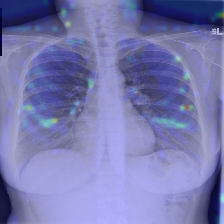

In [87]:
hm = make_gradcam_heatmap(img,base_model,'conv_3_2')
save_and_display_gradcam(img[0], hm)

Clearly, the labels on the x-rays affect the prediction. This warrants the use of a different dataset.

Also, we can try visualizing the weights of the linear attention layer:

In [66]:
vis_attn_model = keras.models.Model(
    inputs=att_model.inputs,
    outputs = att_model.get_layer('Attention_2').output
)

g, c = vis_attn_model.predict(img)
c_softmax = np.exp(c)/np.exp(c).sum()
c.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


(1, 11236, 1)

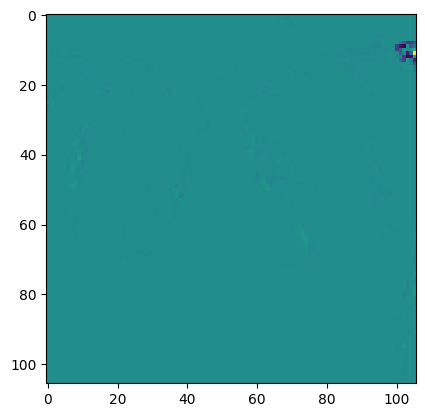

In [67]:
shape = int(np.sqrt(c.shape[-2]))
c_rs = tf.reshape(c, (1,shape, shape))
c_reduced = tf.reduce_mean(c_rs, axis=0)
plt.imshow(c_reduced)

In [69]:
c_reduced_norm = (c_reduced-np.min(c_reduced))/(np.max(c_reduced)-np.min(c_reduced))

<Axes: >

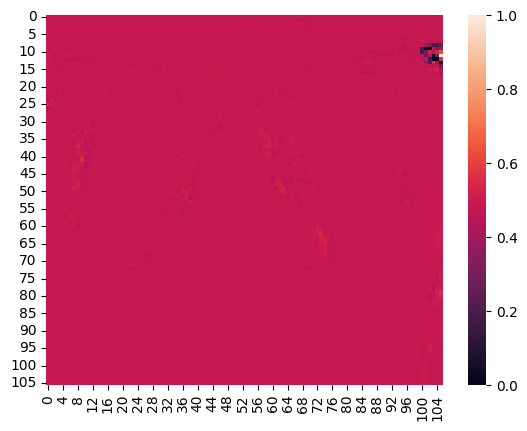

In [70]:
from seaborn import heatmap
heatmap(c_reduced_norm)

(224, 224, 3)


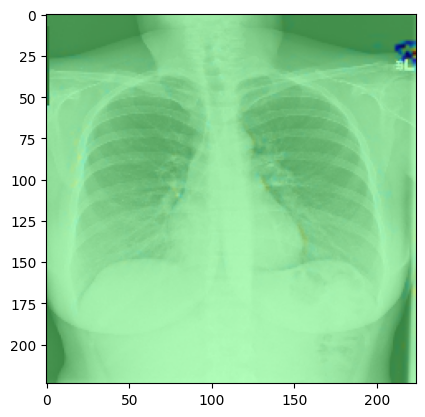

In [71]:
import matplotlib as mpl
heatmap = np.uint8(255 * c_reduced_norm)
    # Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
from IPython.display import Image, display
hmimg = save_and_display_gradcam(img[0], c_reduced_norm,alpha=1, cam_path=f'', save=False)
plt.imshow(hmimg)